In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import itertools
from tqdm.notebook import tqdm

In [3]:
from model.velocity_only.base import *  # my_model = Model()
from model.velocity_only import baseline
from model.helpers import normalize_last_column as compute_q

from plot import plot

# Pragmatic values: demonstrate that it works for one timestep

In [4]:
v_idx = 2
pos_idx = 4
t_idx = 3

qv = np.zeros(n_velocity)
qv[v_idx] = 1.
qp = np.zeros(n_position)
qp[pos_idx] = 1.

qvs = np.zeros((n_action, n_velocity))
qps = np.zeros((n_action, n_position))
for action_idx, a in enumerate(range(n_action)):

    qv_new = qv @ transition_velocity_tavv[t_idx, a, :, :]
    qp_new = qp @ (qv_new @ transition_position_pvp)
    qvs[action_idx] = qv_new
    qps[action_idx] = qp_new

pragmatic = np.sum(qps * log_prior, axis=1)
print("pragmatic values", pragmatic)

e_v = np.zeros(2)
for i in range(2):
    e_v[i] = np.average(velocity, weights=transition_velocity_tavv[t_idx, i, v_idx, :])
print("expected velocities", e_v)

pragmatic values [-45.32330683 -44.13430117]
expected velocities [0.11157895 1.08210526]


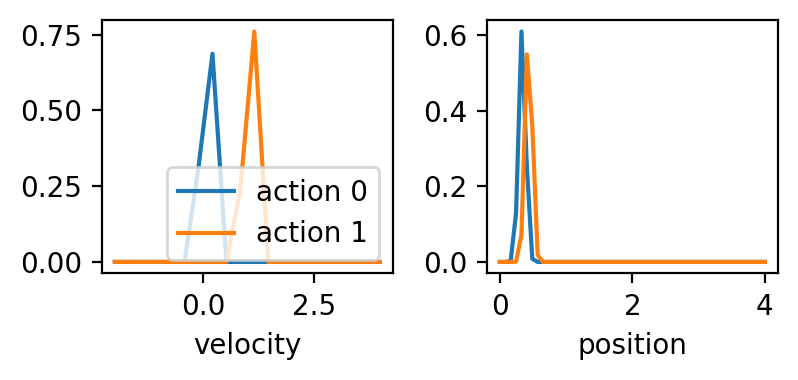

In [5]:
fig, axes = plt.subplots(figsize=(4, 2), ncols=2)

ax = axes[0]
for action_idx, a in enumerate(range(n_action)):
    ax.plot(velocity, qvs[action_idx], label=f"action {a}")

ax.set_xlabel("velocity")
ax.legend(loc="lower right")

ax = axes[1]
for action_idx, a in enumerate(range(n_action)):
    ax.plot(position, qps[action_idx], label=f"action {a}")

ax.set_xlabel("position")
plt.tight_layout()

# Pragmatic values: demonstrate that it works for a run

In [6]:
horizon = 1
n_sample_run = 100

# For logs
hist_pos, hist_vel = np.zeros((n_sample_run, n_timestep)), np.zeros((n_sample_run, n_timestep))

# For each sample...
for sample in range(n_sample_run):

    pos_idx = np.absolute(position).argmin()  # Something close to 0
    v_idx = np.absolute(velocity).argmin() # Something close to 0

    np.random.seed(1234 + sample*123)

    for t_idx in range(n_timestep):

        h = min(horizon, n_timestep - t_idx)
        action_plan = list(itertools.product(range(n_action), repeat=h))

        pragmatic = np.zeros(len(action_plan))
        for ap_index, ap in enumerate(action_plan):

            qvs = np.zeros((h, n_velocity))
            qps = np.zeros((h, n_position))

            qv = np.zeros(n_velocity)
            qv[v_idx] = 1.
            qp = np.zeros(n_position)
            qp[pos_idx] = 1.

            for h_idx in range(h):
                a = ap[h_idx]
                rollout_t_index = t_idx + h_idx
                qv = qv @ transition_velocity_tavv[rollout_t_index, a, :, :]
                qp = qp @ (qv @ transition_position_pvp)
                qvs[h_idx] = qv
                qps[h_idx] = qp

            pragmatic[ap_index] = np.sum(qps @ log_prior)

        a = np.random.choice(
            np.arange(len(action_plan))
            [pragmatic == pragmatic.max()])

        v_idx = np.random.choice(np.arange(n_velocity), p=transition_velocity_tavv[t_idx, a, v_idx, :])
        pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])

        hist_pos[sample, t_idx] = position[pos_idx]
        hist_vel[sample, t_idx] = velocity[v_idx]

run = {
    "policy": "af-pragmatic", 
    "position": hist_pos, 
    "velocity": hist_vel
}

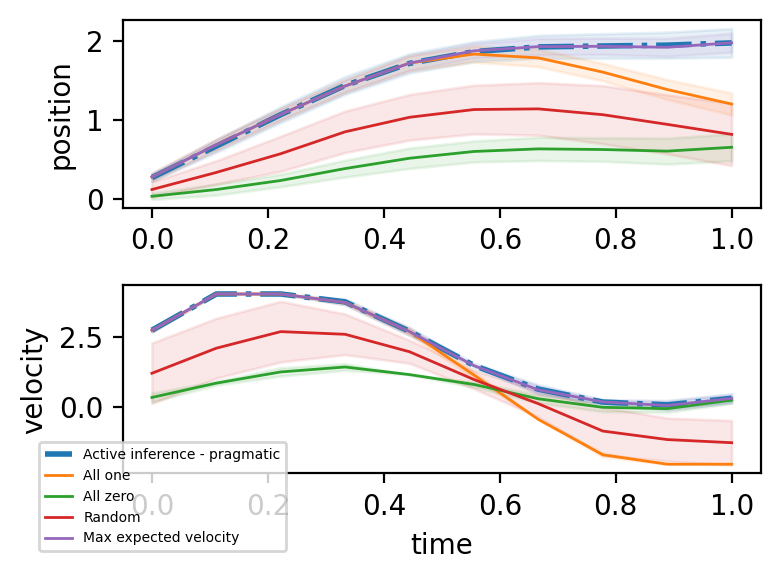

In [7]:
baselines = baseline.run()
plot.runs(run, *baselines)

# Epistemic value

### Learning the model (= inferring the transition) using a RANDOM policy

In [8]:
all_hist_err = {}
policies_err = []

In [12]:
n_episode = 200
n_sample_run = 20
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))

for sample in range(n_sample_run):

    alpha_tavv = np.zeros((n_timestep, n_action, n_velocity, n_velocity)) + np.finfo(np.float64).eps

    if sample == 0:
        error = np.mean(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
        print(f"Initial error {error:.4f}")

    epoch = 0
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin() # Something close to 0

        action_plan = np.random.randint(n_action, size=n_timestep)

        for t_idx, t in enumerate(timestep):

            # Pick new action and draw new velocity
            a = action_plan[t_idx]
            new_v_index = np.random.choice(
                np.arange(n_velocity), 
                p=transition_velocity_tavv[t_idx, a, v_idx, :])

            # Update alpha
            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            alpha_tavv[t_idx, a, v_idx, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])

            # Log
            error = np.mean(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
            hist_err[sample, epoch] = error
            epoch += 1

    print(f"[Sample {sample}] Error after {epoch} epochs {error:.4f}")

run_random = {"policy": "random", "error": hist_err}

Initial error 0.0914
[Sample 0] Error after 2000 epochs 0.0652
[Sample 1] Error after 2000 epochs 0.0650
[Sample 2] Error after 2000 epochs 0.0654
[Sample 3] Error after 2000 epochs 0.0652
[Sample 4] Error after 2000 epochs 0.0650
[Sample 5] Error after 2000 epochs 0.0648
[Sample 6] Error after 2000 epochs 0.0645
[Sample 7] Error after 2000 epochs 0.0651
[Sample 8] Error after 2000 epochs 0.0650
[Sample 9] Error after 2000 epochs 0.0650
[Sample 10] Error after 2000 epochs 0.0647
[Sample 11] Error after 2000 epochs 0.0641
[Sample 12] Error after 2000 epochs 0.0641
[Sample 13] Error after 2000 epochs 0.0648
[Sample 14] Error after 2000 epochs 0.0645
[Sample 15] Error after 2000 epochs 0.0640
[Sample 16] Error after 2000 epochs 0.0643
[Sample 17] Error after 2000 epochs 0.0651
[Sample 18] Error after 2000 epochs 0.0651
[Sample 19] Error after 2000 epochs 0.0649


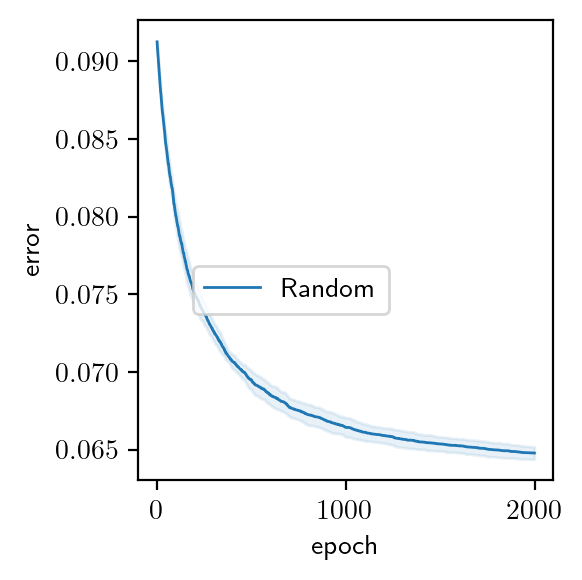

In [13]:
plot.error(run_random)

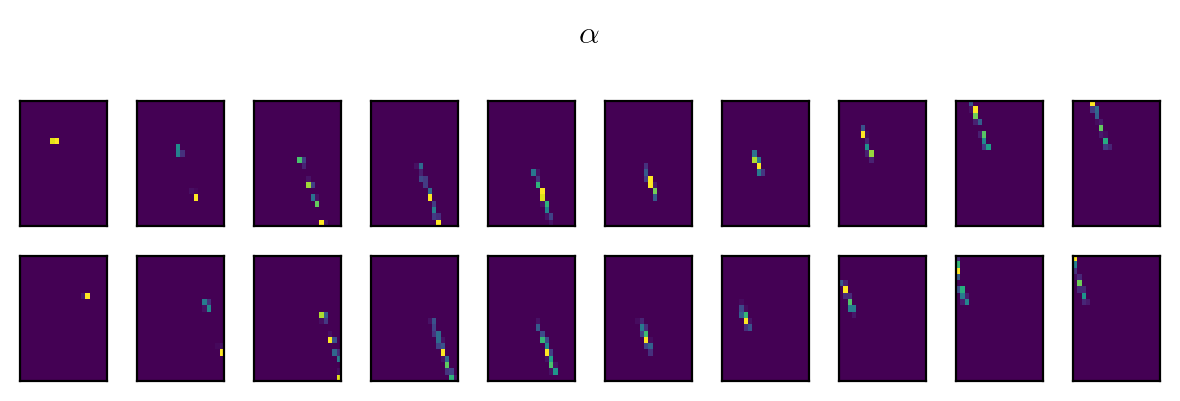

In [14]:
plot.q(alpha_tavv, title=r"$\alpha$")

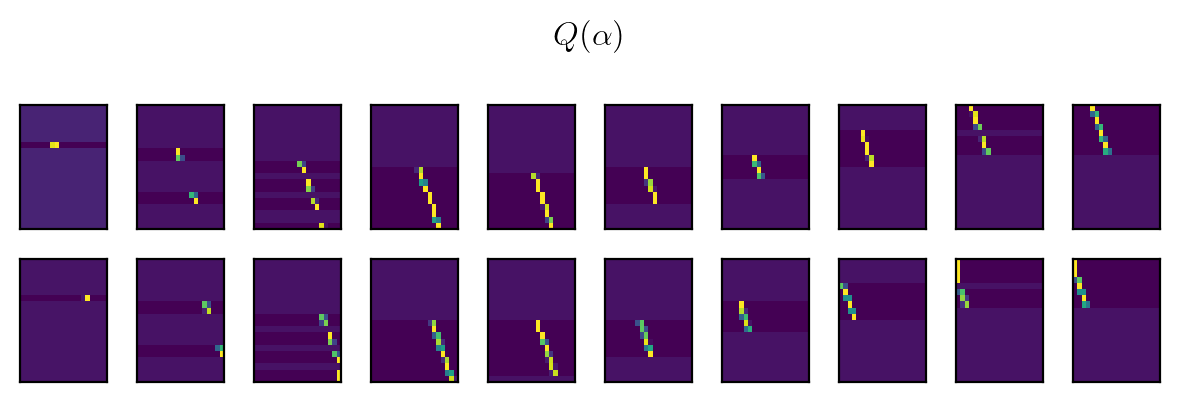

In [15]:
q = compute_q(alpha_tavv)
plot.q(q, title=r"$Q(\alpha)$")

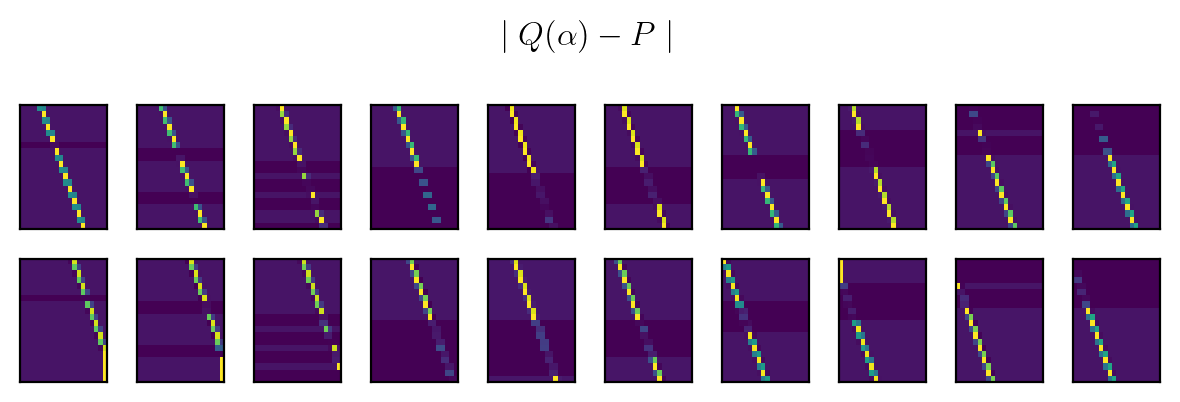

In [16]:
q = compute_q(alpha_tavv)
diff = np.absolute(transition_velocity_tavv - q)
plot.q(diff, title=r"$\mid Q(\alpha) - P \mid$")

In [20]:
n_episode = 200
n_sample_run = 20
horizon = 1  # len(timestep)
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))

for sample in range(n_sample_run):

    # Initialize alpha
    alpha_tavv = np.zeros((n_timestep, n_action, n_velocity, n_velocity)) + np.finfo(np.float64).eps

    # Log error
    error = np.mean(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
    if sample == 0:
        print(f"Initial error {error:.4f}")

    hist_a = []
    epoch = 0

    # with tqdm(total=n_episode) as pbar:
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin()    # Something close to 0

        for t_idx, t in enumerate(timestep):

            h = min(horizon, n_timestep - t_idx)
            action_plan = list(itertools.product(range(n_action), repeat=h))

            # Initialize action plan values
            pragmatic = np.zeros(len(action_plan))
            epistemic = np.zeros(len(action_plan))

            qt = compute_q(alpha_tavv)
            alpha_t = alpha_tavv.copy()

            # Compute value of each action plan
            for ap_index, ap in enumerate(action_plan):

                qvs = np.zeros((h, n_velocity))
                qps = np.zeros((h, n_position))
    
                qv = np.zeros(n_velocity)
                qv[v_idx] = 1.
                qp = np.zeros(n_position)
                qp[pos_idx] = 1.
    
                for h_idx in range(h):
                    previous_qv = qv.copy()
                    
                    a = ap[h_idx]
                    rollout_t_index = t_idx + h_idx
                    
                    _qt = qt[rollout_t_index, a]
                    _alpha = alpha_t[rollout_t_index, a]
                    
                    qv = qv @ _qt
                    
                    # qv = qv @ transition_velocity_tavv[rollout_t_index, a, :, :]
                    qp = qp @ (qv @ transition_position_pvp)
                    
                    # Equation B.34 (p 253) 
                    make_sense = _alpha > 0
                    # _qt += 1e-16
                    w = 1/(2*_alpha) - 1/(2*np.sum(_alpha, axis=-1, keepdims=True))  
                    w = w * make_sense.astype(float)
                    # E_Q[D_KL(Q(o) || Q(o|o'))]
                    v_model = (previous_qv@w)@qv 
                    # v_model /= 10**9
                    
                    # Update qt
                    
                    # Eq B.29 (second term is 0 because the entropy of the likelihood matrices is 0)
                    # H(Q(o)) = - sum_i Q(o_i) log(Q(o_i))
                    # Because the likelihood is trivial, Q(o) = Q(s)
                    # For a justification of the epistemic value for state, see p 137
                    # v_state_p = - qp @ np.log(qp + 1e-16) # ---> Add or remove?
                    # v_state_v = - qv @ np.log(qv + 1e-16)
                    
                    # if h_idx == h-1:
                    epistemic[ap_index] += v_model # + v_state_v  # + v_state_p  # + v_model
                    
                    qvs[h_idx] = qv
                    qps[h_idx] = qp
                
                ## Eq B.28
                ## pragmatic[ap_index] = np.sum(qps @ pref)
                
            # Choose the best action plan
            # Use np.allclose instead of == 
            best_action_plan_index = np.random.choice(np.arange(len(action_plan))[epistemic == epistemic.max()])
            a = action_plan[best_action_plan_index][0]

            new_v_index = np.random.choice(n_velocity, p=transition_velocity_tavv[t_idx, a, v_idx, :])

            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            alpha_tavv[t_idx, a, v_idx, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            pos_idx = np.random.choice(n_position, p=transition_position_pvp[pos_idx, v_idx, :])

            # Log
            error = np.mean(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
            hist_err[sample, epoch] = error
            hist_a.append(a)
            epoch += 1

            # pbar.set_postfix(error=f"{error:.2f}")
            # pbar.update(1)
            
    # print(f"[Sample {sample}] plan {ap} t {h_idx} action {a} v_model {v_model:.2f} v_state_p {v_state_p:.2f} v_state_v {v_state_v:.2f}")

    print(f"[Sample {sample}] Error after {epoch} epochs: {error:.4f}")

    print(f"[Sample {sample}] Freq choose action 0: {100*hist_a.count(0)/len(hist_a):.2f}%")

run_af_epistemic = {"policy": "af-epistemic", "error": hist_err}

Initial error 0.0914
[Sample 0] Error after 2000 epochs: 0.0647
[Sample 0] Freq choose action 0: 50.05%
[Sample 1] Error after 2000 epochs: 0.0640
[Sample 1] Freq choose action 0: 49.85%
[Sample 2] Error after 2000 epochs: 0.0644
[Sample 2] Freq choose action 0: 50.00%
[Sample 3] Error after 2000 epochs: 0.0652
[Sample 3] Freq choose action 0: 50.05%
[Sample 4] Error after 2000 epochs: 0.0646
[Sample 4] Freq choose action 0: 50.05%
[Sample 5] Error after 2000 epochs: 0.0645
[Sample 5] Freq choose action 0: 50.05%
[Sample 6] Error after 2000 epochs: 0.0641
[Sample 6] Freq choose action 0: 50.10%
[Sample 7] Error after 2000 epochs: 0.0649
[Sample 7] Freq choose action 0: 50.00%
[Sample 8] Error after 2000 epochs: 0.0635
[Sample 8] Freq choose action 0: 50.20%
[Sample 9] Error after 2000 epochs: 0.0646
[Sample 9] Freq choose action 0: 49.90%
[Sample 10] Error after 2000 epochs: 0.0653
[Sample 10] Freq choose action 0: 50.05%
[Sample 11] Error after 2000 epochs: 0.0649
[Sample 11] Freq cho

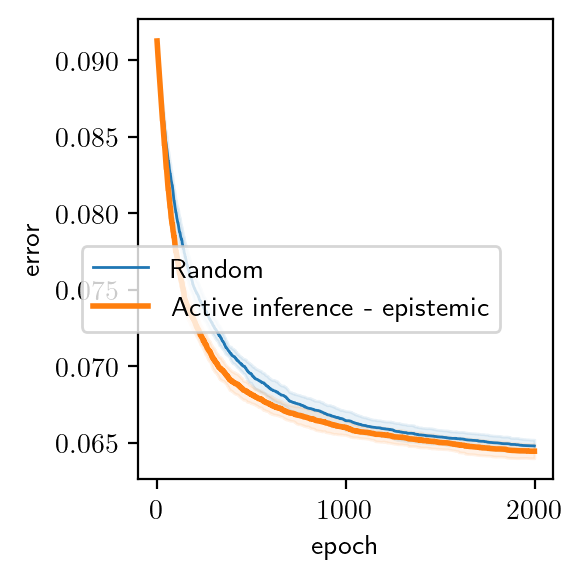

In [21]:
plot.error(run_random, run_af_epistemic)

# All together

In [27]:
def run_af(gammas=None, n_episode=200, n_sample=20, horizon=1, verbose=False):
    
    if gammas is None:
        gammas = np.arange(0, 1.2, 0.2)
        
    if verbose:
        pbar = None
    else:
        pbar = tqdm(total=n_episode*len(gammas)*n_sample*n_timestep) 
    
    runs = []
    for gamma_idx, gamma in enumerate(gammas):
        
        hist_err = np.zeros((n_sample, n_episode*n_timestep))
        hist_pos, hist_vel = np.zeros((n_sample, n_episode, n_timestep)), np.zeros((n_sample, n_episode, n_timestep))
        
        for sample in range(n_sample):
        
            # Initialize alpha
            alpha_tavv = np.zeros((n_timestep, n_action, n_velocity, n_velocity)) + np.finfo(np.float64).eps
        
            # Log error
            # error = np.mean(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
            # print(f"[Sample {sample}] Initial error {error:.4f}")
        
            hist_a = []
            epoch = 0
        
            # with tqdm(total=n_episode) as pbar:
            for ep_idx in range(n_episode):
        
                np.random.seed(12334 + ep_idx + sample * 2 + gamma_idx * 3)
        
                pos_idx = np.absolute(position).argmin()  # Something close to 0
                v_idx = np.absolute(velocity).argmin()    # Something close to 0
        
                for t_idx, t in enumerate(timestep):
        
                    h = min(horizon, n_timestep - t_idx)
                    action_plan = list(itertools.product(range(n_action), repeat=h))
        
                    # Initialize action plan values
                    pragmatic = np.zeros(len(action_plan))
                    epistemic = np.zeros(len(action_plan))
        
                    qt = compute_q(alpha_tavv)
                    alpha_t = alpha_tavv.copy()
        
                    # Compute value of each action plan
                    for ap_index, ap in enumerate(action_plan):
        
                        qvs = np.zeros((h, n_velocity))
                        qps = np.zeros((h, n_position))
            
                        qv = np.zeros(n_velocity)
                        qv[v_idx] = 1.
                        qp = np.zeros(n_position)
                        qp[pos_idx] = 1.
            
                        for h_idx in range(h):
                            
                            previous_qv = qv.copy()
                            
                            a = ap[h_idx]
                            rollout_t_index = t_idx + h_idx
                            
                            _qt = qt[rollout_t_index, a]
                            _alpha = alpha_t[rollout_t_index, a]
                            
                            qv = qv @ _qt  # Using beliefs about velocity transitions
                            qp = qp @ (qv @ transition_position_pvp)
                            
                            # Equation B.34 (p 253) 
                            make_sense = _alpha > 0
                            # _qt += 1e-16
                            w = 1/(2*_alpha) - 1/(2*np.sum(_alpha, axis=-1, keepdims=True))  
                            w = w * make_sense.astype(float)
                            # E_Q[D_KL(Q(o) || Q(o|o'))]
                            v_model = (previous_qv@w)@qv
                            
                            # Eq B.29
                            # H(Q(o)) = - sum_i Q(o_i) log(Q(o_i)) - E_Q(s)[H[P(o |s)]]
                            # For a justification of the epistemic value for state, see p 137
                            # The second term is 0 because the entropy of the likelihood matrices is 0
                            # Because the likelihood is trivial, Q(o) = Q(s)
                            # v_state_p = - qp @ np.log(qp + 1e-16) # ---> Add or remove?
                            # v_state_v = - qv @ np.log(qv + 1e-16) # ---> Add or remove?
                            # v_state_c = - 0   # Context is known and perfectly predictable in this case
                            
                            # if h_idx == h-1:
                            epistemic[ap_index] += v_model # + v_state_v  # + v_state_p  # + v_model
                            
                            qvs[h_idx] = qv
                            qps[h_idx] = qp
                        
                        # Eq B.28
                        pragmatic[ap_index] = np.sum(qps @ log_prior)
                        
                    # Choose the best action plan
                    efe = gamma*epistemic + pragmatic
                    best_action_plan_index = np.random.choice(np.arange(len(action_plan))[np.isclose(efe, efe.max())])
                    a = action_plan[best_action_plan_index][0]
        
                    new_v_index = np.random.choice(n_velocity, p=transition_velocity_tavv[t_idx, a, v_idx, :])
        
                    # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
                    alpha_tavv[t_idx, a, v_idx, new_v_index] += 1
        
                    # Update velocity and position
                    v_idx = new_v_index
                    pos_idx = np.random.choice(n_position, p=transition_position_pvp[pos_idx, v_idx, :])
        
                    # Log
                    error = np.mean(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
                    hist_err[sample, epoch] = error
                    hist_pos[sample, ep_idx, t_idx] = position[pos_idx]  
                    hist_vel[sample, ep_idx, t_idx] = velocity[v_idx]
                    hist_a.append(a)
                    epoch += 1
        
                    if pbar is not None:
                        pbar.update(1)

            if verbose:
                print(f"[Sample {sample}] Last position at the last episode {hist_pos[sample, -1, -1]:.2f}")
        
        runs.append({
            "gamma": gamma,
            "policy": "af", 
            "error": hist_err, 
            "position": hist_pos[:, :, :],  
            "velocity": hist_vel[:, :, :]})
    if pbar is not None:
        pbar.close()
    return runs

In [28]:
runs = run_af()

  0%|          | 0/240000 [00:00<?, ?it/s]

In [29]:
best_baseline = [r for r in baselines if r["policy"] == 'max-expected-velocity'][0]
best_baseline__position = best_baseline["position"][:, -1].mean()

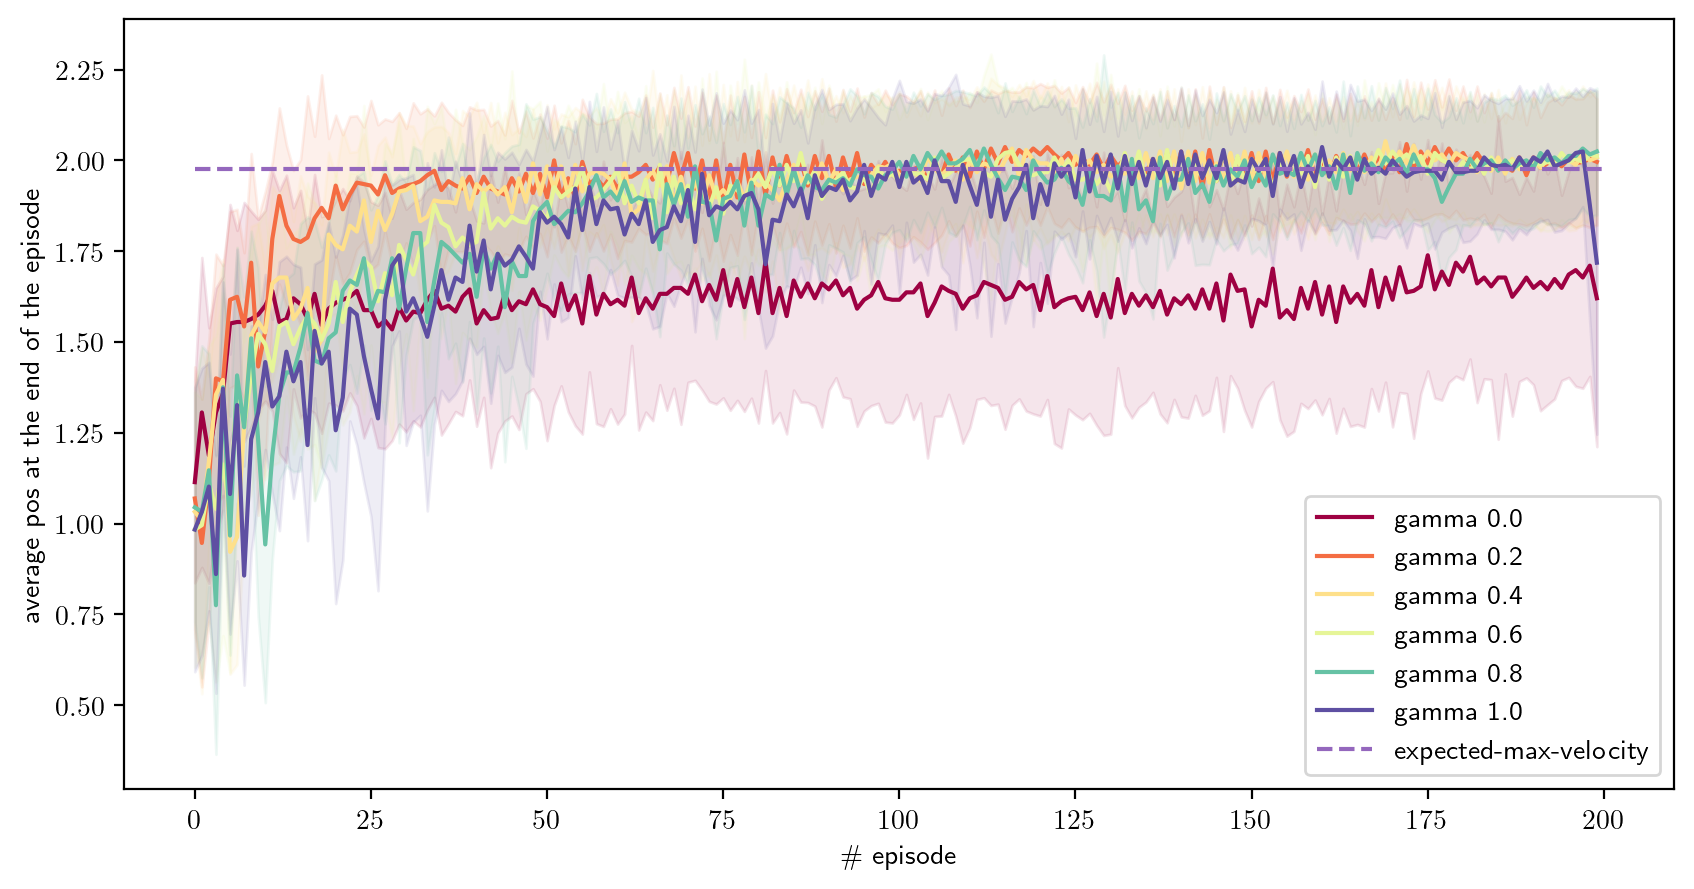

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))

cmap = cm.get_cmap('Spectral')

for i, run in enumerate(runs):
    
    hist_pos = run["position"]
    gamma = run["gamma"]
    
    hist_mean = np.mean(hist_pos[:, :, -1], axis=0)
    hist_std = np.std(hist_pos[:, :, -1], axis=0)
    
    color = cmap(gamma)

    ax.fill_between(np.arange(len(hist_mean)), hist_mean - hist_std, hist_mean + hist_std, alpha=0.1, color=color)
    ax.plot(np.arange(len(hist_mean)), hist_mean, color=color, label=f"gamma {gamma:.1f}")
    
    
ax.hlines(best_baseline__position, 0, runs[0]["position"].shape[1], color="C4", linestyle="--", label="expected-max-velocity")
ax.legend()
ax.set_xlabel(r"\# episode")
ax.set_ylabel("average pos at the end of the episode");

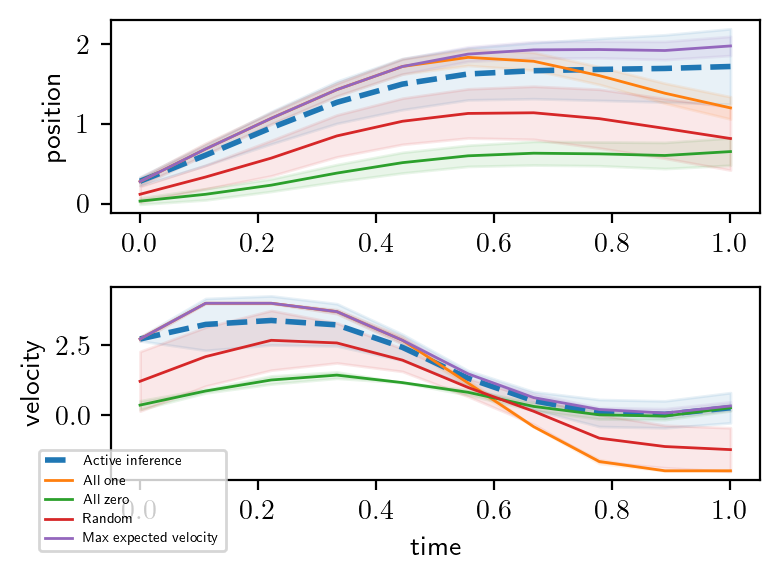

In [32]:
plot.runs(
    [_ for _ in runs if _["gamma"] == 1.0][0], # Run gamma = 1
    *baselines)